# Proving Cluster Algorithms Can Be Classifiers 
In this notebook we will prove that clustering algorithms (KMeans and Agglomerative) can be used to classify items in a most difficult scenario, credit scoring. The clustering algorithms won't know what the target variables are during training or predicting. We'll have to match the random classes assigned to each observation to the most likely classes after the fact, and then be able to score the result against the known classes. Once we have some results, we'll compare them to an untuned random forest to see how well the system is working. The two classifiers (KMeans and Agglomerative) also showcase the difference in predictive capabilities for clustering algorithms. Further, we'll show that clustering classifiers are orders of magnitude faster to set up than the most accurate supervised algorithms with many hyperparameters. Finally we'll compare the results and time commitments. Specifically, that clustering algorithms can classify faster but are not quite as accurate.

# Dataset 
The data for this exploration is a publicly available dataset on Kaggle. Although the dataset only garners a 6.4 score (not all observations can be classified by even the best classifiers), it will work well for us. I appreciate the complexity of this task, and want to see how clustering algorithms perform as classifiers in less than ideal situations. Since the dataset is large (100,000 observations in the training set alone) it will be more than adequate for this exploration. The dataset can be found here on Kaggle:

https://www.kaggle.com/datasets/clkmuhammed/creditscoreclassification

# Limitations
Before we begin, this notebook is going to be RAM limited. The 100,000 observations is too much for the FREE kaggle notebook allocation. We will have to resample the dataset to make this work... We'll also need to strip down the columns to reduce the RAM load. The best case after stripping the columns is a classifier with roughly 75% accuracy (we're removing data needed to make the remaining predictions). As we compare the results we will use this lowered goal as the comparison for our classifiers.

Let's begin by importing some libraries...

In [40]:
 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
#!pip install yellowbrick  
#from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans , AgglomerativeClustering
import matplotlib.pyplot as plt
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score
from sklearn.decomposition import FactorAnalysis
from sklearn.model_selection import cross_val_score
import warnings, time
warnings.filterwarnings("ignore")
import os, sys
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

pd.set_option('display.float_format', lambda x: '%.4f' % x)
sys.setrecursionlimit(10**9)

/kaggle/input/creditscoreclassification/credit_score_multi_class_xgboost_model.json
/kaggle/input/creditscoreclassification/get_dummies.py
/kaggle/input/creditscoreclassification/credit_score_multi_class_le.pkl
/kaggle/input/creditscoreclassification/credit_score_multi_class_ord_encoder.pkl
/kaggle/input/creditscoreclassification/train.csv
/kaggle/input/creditscoreclassification/test.csv
/kaggle/input/creditscoreclassification/credit_score_multi_class_dummy.pkl


# Exploratory Data Analysis

Now that we have our libraries loaded, let's import the data into a dataframe, see the shape, column names, info, and descriptive statistics.

In [41]:
scores = pd.read_csv('/kaggle/input/creditscoreclassification/train.csv')
scores.shape

(100000, 28)

In [42]:
scores.columns

Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score'],
      dtype='object')

In [43]:
scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  int64  
 1   Customer_ID               100000 non-null  int64  
 2   Month                     100000 non-null  int64  
 3   Name                      100000 non-null  object 
 4   Age                       100000 non-null  float64
 5   SSN                       100000 non-null  float64
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  float64
 8   Monthly_Inhand_Salary     100000 non-null  float64
 9   Num_Bank_Accounts         100000 non-null  float64
 10  Num_Credit_Card           100000 non-null  float64
 11  Interest_Rate             100000 non-null  float64
 12  Num_of_Loan               100000 non-null  float64
 13  Type_of_Loan              100000 non-null  ob

In [44]:
scores.describe()

,ID,Customer_ID,Month,Age,SSN,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,...,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance
count,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,...,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000
mean,80631.5000,25982.6666,4.5000,33.3163,500461680.2624,50505.1234,4197.2708,5.3688,5.5336,14.5321,...,21.0814,13.3131,10.4703,5.7983,1426.2204,32.2852,221.2205,107.6992,55.1013,392.6976
std,43301.4866,14340.5431,2.2913,10.7648,290826734.3862,38299.4221,3186.4325,2.5933,2.0671,8.7413,...,14.8046,6.2372,6.6095,3.8678,1155.1290,5.1169,99.6807,132.2671,39.0069,201.6527
min,5634.0000,1006.0000,1.0000,14.0000,81349.0000,7005.9300,303.6454,0.0000,0.0000,1.0000,...,0.0000,0.0000,0.5000,0.0000,0.2300,20.0000,1.0000,0.0000,0.0000,0.0078
25%,43132.7500,13664.5000,2.7500,24.0000,245168577.2500,19342.9725,1626.5942,3.0000,4.0000,7.0000,...,10.0000,9.0000,5.3800,3.0000,566.0725,28.0526,144.0000,29.2689,27.9591,267.6160
50%,80631.5000,25777.0000,4.5000,33.0000,500688611.5000,36999.7050,3095.9050,5.0000,5.0000,13.0000,...,18.0000,14.0000,9.4000,5.0000,1166.1550,32.3058,219.0000,66.4623,45.1565,333.8654
75%,118130.2500,38385.0000,6.2500,42.0000,756002666.2500,71683.4700,5957.7150,7.0000,7.0000,20.0000,...,28.0000,18.0000,14.8500,8.0000,1945.9625,36.4967,302.0000,147.3926,71.2958,463.2157
max,155629.0000,50999.0000,8.0000,56.0000,999993421.0000,179987.2800,15204.6333,11.0000,11.0000,34.0000,...,62.0000,25.0000,29.9800,17.0000,4998.0700,50.0000,404.0000,1779.1033,434.1911,1183.9307


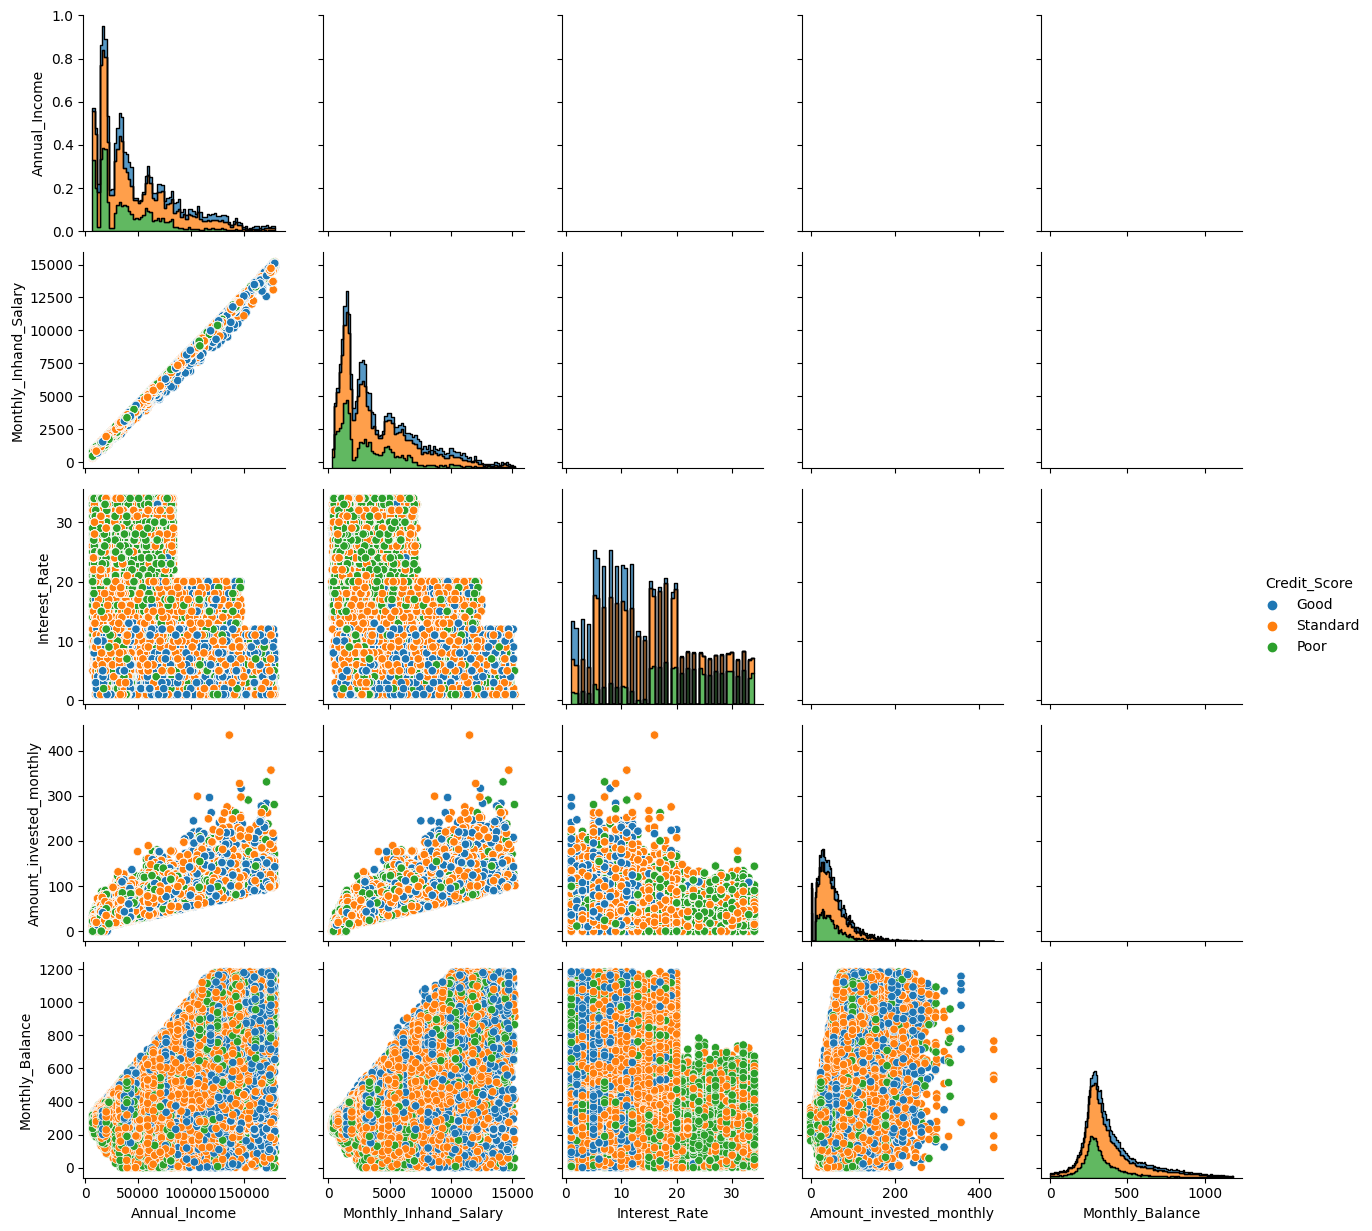

In [45]:
grid = sns.PairGrid(scores,vars = ['Annual_Income', 'Monthly_Inhand_Salary',
         'Interest_Rate',  
       'Amount_invested_monthly',   'Monthly_Balance'
       ] , hue='Credit_Score')
grid = grid.map_lower(sns.scatterplot)
grid = grid.map_diag(sns.histplot,multiple="stack",element="step")

grid.add_legend()

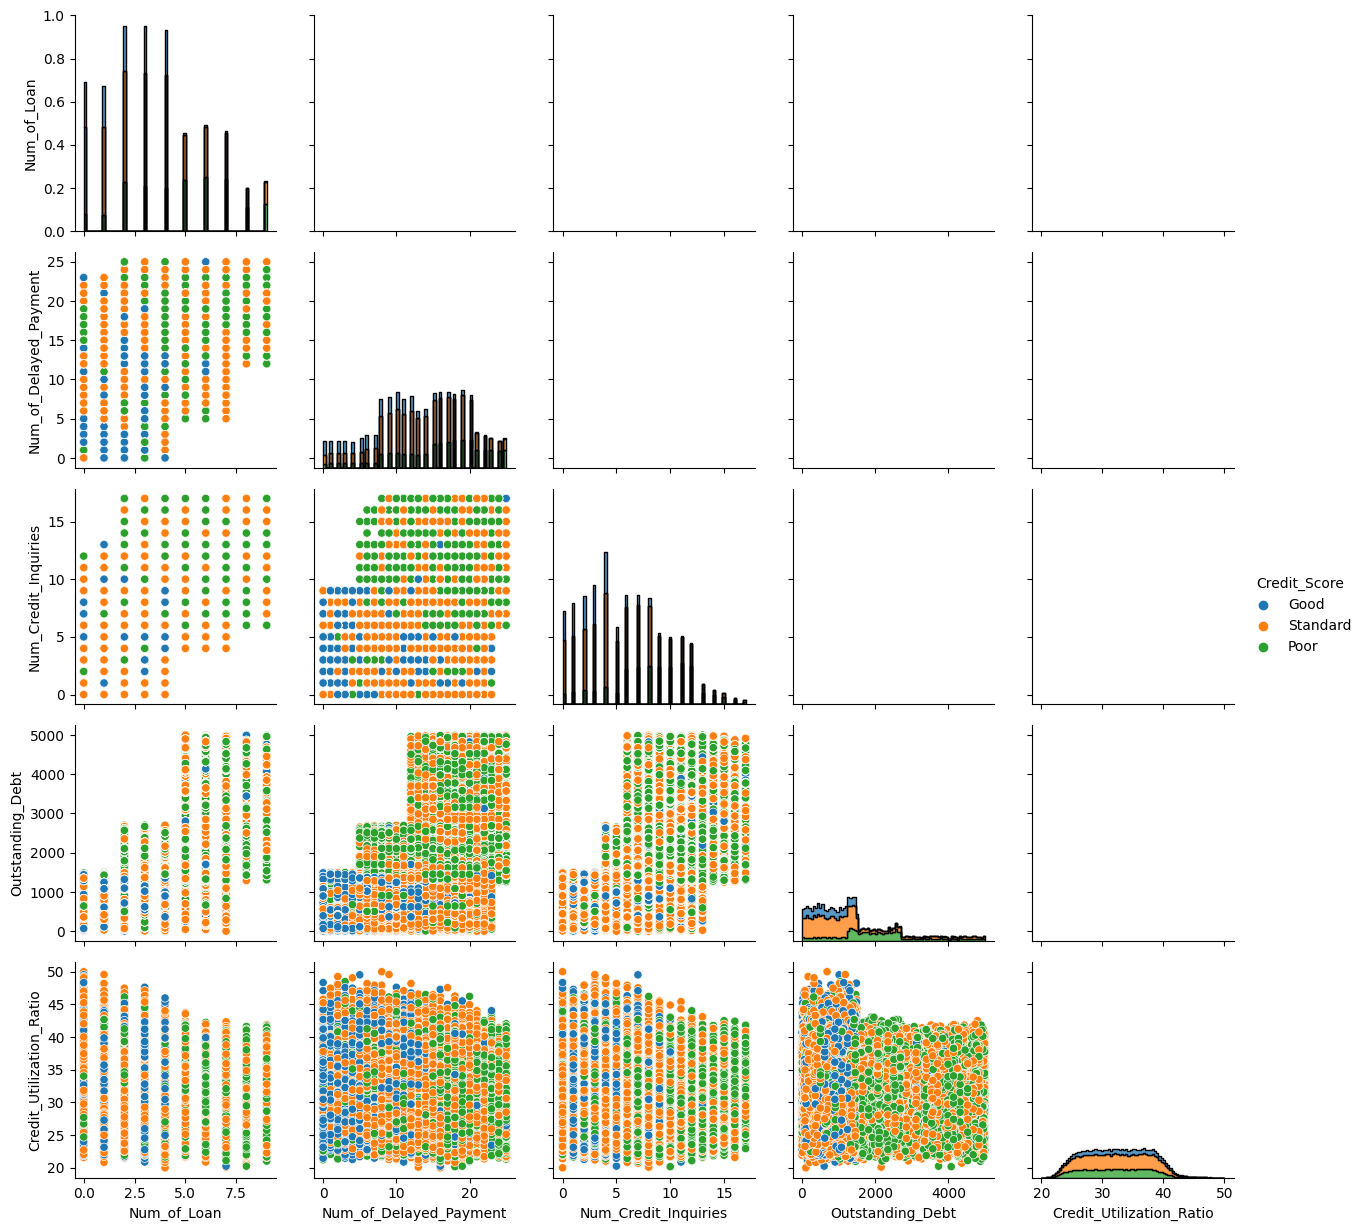

In [46]:
grid = sns.PairGrid(scores,vars = ['Num_of_Loan',
        'Num_of_Delayed_Payment', 
       'Num_Credit_Inquiries',   'Outstanding_Debt',
       'Credit_Utilization_Ratio'] , hue='Credit_Score')
grid = grid.map_lower(sns.scatterplot)
grid = grid.map_diag(sns.histplot,multiple="stack",element="step")

grid.add_legend()

Great. We have a dataset with 100,000 lines, 28 columns, no null values, and 7 categorical variables. Based on the pairplots we can see that there is relatively little correlation on most variables except those we'd expect (like Annual Income and Monthly In Hand Salary). There is a little bit of clustering of the classes across the variables, but not much. The pair plots show how tough a classification task this is.

Let's see if the data is balanced across our target variable?

In [47]:
scores.Credit_Score.value_counts()

Credit_Score
Standard    53174
Poor        28998
Good        17828
Name: count, dtype: int64

In [48]:
# arbitrarily (randomly) balance the classes using the least prevalent class
df1 = scores.loc[scores['Credit_Score']=='Good'].sample(17828,random_state=124)
df2 = scores.loc[scores['Credit_Score']=='Standard'].sample(17828,random_state=124)
df3 = scores.loc[scores['Credit_Score']=='Poor'].sample(17828,random_state=124)
scorestot = pd.concat([df1,df2,df3]) 
scorestot.describe()

,ID,Customer_ID,Month,Age,SSN,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,...,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance
count,53484.0000,53484.0000,53484.0000,53484.0000,53484.0000,53484.0000,53484.0000,53484.0000,53484.0000,53484.0000,...,53484.0000,53484.0000,53484.0000,53484.0000,53484.0000,53484.0000,53484.0000,53484.0000,53484.0000,53484.0000
mean,80545.3813,26096.6441,4.5494,33.6913,498291722.5823,52326.9592,4345.7346,5.1169,5.3878,13.8749,...,20.1802,12.6488,9.8596,5.6073,1386.2833,32.3531,227.9811,111.4888,56.6881,399.5064
std,43294.5436,14308.8431,2.2872,10.8555,290513247.1221,39721.5376,3302.0653,2.6919,2.1455,8.9440,...,15.0876,6.5129,6.4595,3.8942,1125.9999,5.1335,99.2471,143.5657,40.2973,206.4248
min,5634.0000,1006.0000,1.0000,14.0000,81349.0000,7005.9300,303.6454,0.0000,0.0000,1.0000,...,0.0000,0.0000,0.5000,0.0000,0.2300,20.1729,1.0000,0.0000,0.0000,0.0078
25%,43124.7500,13907.7500,3.0000,25.0000,242158827.0000,19754.8775,1663.9142,3.0000,4.0000,7.0000,...,9.0000,8.0000,4.8600,2.0000,553.4300,28.1030,154.0000,28.9358,28.4524,269.8826
50%,80624.5000,26015.0000,5.0000,33.0000,498140072.0000,38443.4200,3196.5591,5.0000,5.0000,12.0000,...,16.0000,13.0000,8.8100,5.0000,1140.6300,32.3781,227.0000,66.8661,46.3901,338.9089
75%,117992.2500,38480.0000,7.0000,42.0000,751267144.0000,73997.6200,6161.7950,7.0000,7.0000,20.0000,...,27.0000,18.0000,13.5000,8.0000,1864.1100,36.5741,310.0000,150.6906,73.6630,472.4864
max,155629.0000,50999.0000,8.0000,56.0000,999993421.0000,179987.2800,15204.6333,11.0000,11.0000,34.0000,...,62.0000,25.0000,29.9800,17.0000,4998.0700,49.5645,404.0000,1779.1033,434.1911,1183.9307


In [49]:
# arbitrarily (randomly) siphon off ~ 90% of the data for training
df1 = scorestot.loc[scores['Credit_Score']=='Good'].sample(15874,random_state=124)
df2 = scorestot.loc[scores['Credit_Score']=='Standard'].sample(15874,random_state=124)
df3 = scorestot.loc[scores['Credit_Score']=='Poor'].sample(15874,random_state=124)
scorestr = pd.concat([df1,df2,df3]) 
scorestr.describe()

,ID,Customer_ID,Month,Age,SSN,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,...,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance
count,47622.0000,47622.0000,47622.0000,47622.0000,47622.0000,47622.0000,47622.0000,47622.0000,47622.0000,47622.0000,...,47622.0000,47622.0000,47622.0000,47622.0000,47622.0000,47622.0000,47622.0000,47622.0000,47622.0000,47622.0000
mean,80497.7970,26098.5082,4.5503,33.6609,498386846.0251,52350.0794,4347.4008,5.1127,5.3870,13.8794,...,20.1748,12.6508,9.8635,5.6071,1386.6157,32.3606,227.9345,111.5976,56.6601,399.8578
std,43255.3902,14301.0896,2.2846,10.8572,290638634.9354,39716.5500,3301.5532,2.6944,2.1482,8.9510,...,15.0972,6.5175,6.4637,3.8960,1126.2750,5.1356,99.3690,143.5772,40.2613,206.4086
min,5634.0000,1006.0000,1.0000,14.0000,81349.0000,7005.9300,303.6454,0.0000,0.0000,1.0000,...,0.0000,0.0000,0.5000,0.0000,0.2300,20.1729,1.0000,0.0000,0.0000,0.0078
25%,43184.2500,13905.2500,3.0000,25.0000,242192851.0000,19786.3600,1666.0575,3.0000,4.0000,7.0000,...,9.0000,8.0000,4.8600,2.0000,553.4300,28.1086,154.0000,28.8816,28.4991,270.1469
50%,80574.5000,26011.0000,5.0000,33.0000,497637268.0000,38436.6800,3195.0125,5.0000,5.0000,12.0000,...,16.0000,13.0000,8.8100,5.0000,1141.6800,32.3826,227.0000,66.9568,46.3613,339.2472
75%,117874.7500,38462.0000,7.0000,42.0000,751640582.7500,74017.0800,6161.7950,7.0000,7.0000,20.0000,...,27.0000,18.0000,13.5200,8.0000,1862.2200,36.5957,310.0000,150.8210,73.5026,473.3708
max,155629.0000,50999.0000,8.0000,56.0000,999957259.0000,179987.2800,15204.6333,11.0000,11.0000,34.0000,...,62.0000,25.0000,29.9800,17.0000,4998.0700,49.5645,404.0000,1779.1033,434.1911,1183.9307


In [50]:
# build a test set from what remains in the balanced dataset, and checksums in scorestot
# Set Dummy Variable Columns
scorestot["TrainSet"] = 0
scorestot['TestSet'] = 1

# Add each train row to its set
for i in scorestr.ID: 
    scorestot['TrainSet'].loc[scorestot['ID'] == i] = 1
    scorestot['TestSet'].loc[scorestot['ID'] == i] = 0

# Export the Test Dataframe (the remaining ones in TestSet column) and inspect
scoreste = scorestot.loc[scorestot['TestSet'] == 1]
scoreste.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5862 entries, 48394 to 21349
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        5862 non-null   int64  
 1   Customer_ID               5862 non-null   int64  
 2   Month                     5862 non-null   int64  
 3   Name                      5862 non-null   object 
 4   Age                       5862 non-null   float64
 5   SSN                       5862 non-null   float64
 6   Occupation                5862 non-null   object 
 7   Annual_Income             5862 non-null   float64
 8   Monthly_Inhand_Salary     5862 non-null   float64
 9   Num_Bank_Accounts         5862 non-null   float64
 10  Num_Credit_Card           5862 non-null   float64
 11  Interest_Rate             5862 non-null   float64
 12  Num_of_Loan               5862 non-null   float64
 13  Type_of_Loan              5862 non-null   object 
 14  Delay_fr

In [51]:
#inspection
scoreste['Credit_Score'].value_counts()
print("Scores TOT Length:",len(scorestot.ID.unique()))
print("\nScores Train Length:",len(scorestr.ID.unique()))
print("Sum Train Checksum:",scorestot.TrainSet.sum())

print("\nScores Test Length:",len(scoreste.ID.unique()))
print("Sum Test Checksum:",scorestot.TestSet.sum())
 

Scores TOT Length: 53484

Scores Train Length: 47622
Sum Train Checksum: 47622

Scores Test Length: 5862
Sum Test Checksum: 5862


We only have a few things left to do before clustering. 

# Data Preprocessing - Numeric Classes
Next, we need to put numeric values into a column of our dataframe so that numpy can compare against them later. We'll use numbers 3, 4, and 5 for our arbitrary class names. (Numbers 0, 1, and 2 will be used by the clustering algorithms arbitrarily. We choose dummy values above these.) Once we have numerical class categories, we can use Numpy Arrays to compare our predictions against the numeric class truth. 

In [52]:
# Ensure there are only 3 classes...
clusternames = scores.Credit_Score.unique()
clusternames

array(['Good', 'Standard', 'Poor'], dtype=object)

In [53]:
#assign dummy numerical classes
clustervals = [3,4,5]
scorestr['ScoreNum'] = 0
scorestr['ScoreNum'].loc[scorestr['Credit_Score']=='Good'] = 3
scorestr['ScoreNum'].loc[scorestr['Credit_Score']=='Standard'] = 4
scorestr['ScoreNum'].loc[scorestr['Credit_Score']=='Poor'] = 5

scoreste['ScoreNum'] = 0
scoreste['ScoreNum'].loc[scoreste['Credit_Score']=='Good'] = 3
scoreste['ScoreNum'].loc[scoreste['Credit_Score']=='Standard'] = 4
scoreste['ScoreNum'].loc[scoreste['Credit_Score']=='Poor'] = 5

print(scorestr[['Credit_Score','ScoreNum']].head())
print(scorestr['ScoreNum'].value_counts())


print(scoreste[['Credit_Score','ScoreNum']].head())
print(scoreste['ScoreNum'].value_counts())

      Credit_Score  ScoreNum
47905         Good         3
53474         Good         3
37118         Good         3
6322          Good         3
44263         Good         3
ScoreNum
3    15874
4    15874
5    15874
Name: count, dtype: int64
      Credit_Score  ScoreNum
48394         Good         3
60325         Good         3
70694         Good         3
66214         Good         3
14280         Good         3
ScoreNum
3    1954
4    1954
5    1954
Name: count, dtype: int64


# Data Preprocessing - Copy Dataframes and Normalize Data
Some algoritms we plan to use need normalized data (0 to 1, z scored, or equivalent) to efficiently and properly measure distance across a multi-dimensional space. Some algorithms work better with the original data. Making the data conform to both needs will be a three step process. First, we'll go ahead and copy our original train and test dataframes to prepare accounting for these differences (2 = normalized, 3 = original). 

Next, we'll drop the columns we won't be using in the algorithms. The test sets won't need the Credit Score or Credit Numbers we generated above. Before we normalize, we'll copy the data to preserve a non-normalized dataset. Then we normalize the data in a set of dataframes.

In [54]:
# copy dataframes and drop columns in the copy
scores2 = scorestr.copy()
scores2te = scoreste.copy()
scores2.drop(columns=[ "Customer_ID",'Name','Occupation','Month','SSN','Type_of_Loan','Credit_Mix','Payment_of_Min_Amount','Payment_Behaviour','Credit_Score'],inplace=True)
scores2te.drop(columns=[ "Customer_ID",'Name','Occupation','Month','SSN','Type_of_Loan','Credit_Mix','Payment_of_Min_Amount','Payment_Behaviour','Credit_Score','TrainSet','TestSet'],inplace=True)

# preserve a set for non-normalized
scores3 = scores2.copy()
scores3te = scores2te.copy()

# normalize the data (Except the IDs and ScoreNums)
for column in scores2.columns[1:-1]: # Skip the ID and ScoreNum Columns
    scores2[column] = (scores2[column] - scores2[column].min()) / (scores2[column].max()-scores2[column].min())
    scores2te[column] = (scores2te[column] - scores2te[column].min()) / (scores2te[column].max()-scores2te[column].min())
print("Scores Test Frame Shape:",scores2.shape)
scores2.describe()

Scores Test Frame Shape: (47622, 19)


,ID,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,ScoreNum
count,47622.0000,47622.0000,47622.0000,47622.0000,47622.0000,47622.0000,47622.0000,47622.0000,47622.0000,47622.0000,47622.0000,47622.0000,47622.0000,47622.0000,47622.0000,47622.0000,47622.0000,47622.0000,47622.0000
mean,80497.7970,0.4681,0.2621,0.2714,0.4648,0.4897,0.3903,0.3804,0.3254,0.5060,0.3176,0.3298,0.2774,0.4147,0.5631,0.0627,0.1305,0.3377,4.0000
std,43255.3902,0.2585,0.2296,0.2216,0.2449,0.1953,0.2712,0.2688,0.2435,0.2607,0.2193,0.2292,0.2254,0.1747,0.2466,0.0807,0.0927,0.1743,0.8165
min,5634.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000
25%,43184.2500,0.2619,0.0739,0.0914,0.2727,0.3636,0.1818,0.2222,0.1452,0.3200,0.1479,0.1176,0.1107,0.2700,0.3797,0.0162,0.0656,0.2282,3.0000
50%,80574.5000,0.4524,0.1817,0.1940,0.4545,0.4545,0.3333,0.3333,0.2581,0.5200,0.2819,0.2941,0.2284,0.4154,0.5608,0.0376,0.1068,0.2865,4.0000
75%,117874.7500,0.6667,0.3874,0.3931,0.6364,0.6364,0.5758,0.5556,0.4355,0.7200,0.4417,0.4706,0.3726,0.5588,0.7667,0.0848,0.1693,0.3998,5.0000
max,155629.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,5.0000


With two dataframes, target variables numerically identified, and EDA complete, let's cluster.

# KMeans Clustering

We have 3 classes, so we'll ask KMeans to cluster into 3 groups. We define a random state so the results are repeatable and put a maximum number of iterations on the modeler just in case. Once we've defined the model parameters, we feed in the data. Asking the model for predictions at the same time as fitting is done with the fit_predict() method below.

In [55]:
t0 = time.time()
#Define the KMeans classifier
km = KMeans(n_clusters=3, max_iter=300, random_state=212, tol=.0001)

#Run the Classifier
firstrun = km.fit_predict(scores2.iloc[:,1:-1])
print("Predictions Length:",len(firstrun),"\nType and Values:",type(firstrun),firstrun)
kmt1 =  round(time.time()-t0,3)
print("Completed in ",kmt1, ' seconds.')

Predictions Length: 47622 
Type and Values: <class 'numpy.ndarray'> [2 2 2 ... 0 2 2]
Completed in  1.983764886856079  seconds.


Great. We have arbitrary classes 0, 1, & 2. Now we need to see which clusters match to which variables. We'll cycle through and see the scores for each combination, and then pick the pairings with the highest scores.

In [56]:
bests = []
for j in range(3,6):
    placeholder = []
    accstep = 0
    clu = ''
    val = ''
    for i in range(3):
        placeholder = firstrun.copy()
        #print(len(placeholder))
        placeholder[placeholder == i] = j
        accs = accuracy_score(scorestr.ScoreNum,placeholder)
        print('Target:', j ," Cluster:",i," Accuracy:",accs)
        if accs > accstep:
            accstep = accs
            val = j
            clu = i
    bests.append([accstep,clu,val])

#assign second best option by hand for a class
bests[0][1]=1   
bests

Target: 3  Cluster: 0  Accuracy: 0.011780269623283357
Target: 3  Cluster: 1  Accuracy: 0.12897400361177608
Target: 3  Cluster: 2  Accuracy: 0.1925790600982739
Target: 4  Cluster: 0  Accuracy: 0.08674562177145018
Target: 4  Cluster: 1  Accuracy: 0.07288648103817563
Target: 4  Cluster: 2  Accuracy: 0.17370123052370753
Target: 5  Cluster: 0  Accuracy: 0.24698668682541683
Target: 5  Cluster: 1  Accuracy: 0.03053210700936542
Target: 5  Cluster: 2  Accuracy: 0.05581453949855109


[[0.1925790600982739, 1, 3],
 [0.17370123052370753, 2, 4],
 [0.24698668682541683, 0, 5]]

This series of outputs show how difficult this task truly is for our clustering classifier. If picking the highest scoring Cluster to Target for each pairing allows us to move on to the next stage we are done. But that's not what we are able to do here. I have to choose the second best option for a cluster by hand. (assigning cluster 0 to target 4). 

* The KMeans classifier is not able to differentiate between the Poor and Standard credit classes well with these variables.
* The task we are attempting is nuanced by variables of different scales, and our scaling of all variables wasn't sufficient to fix the problem.

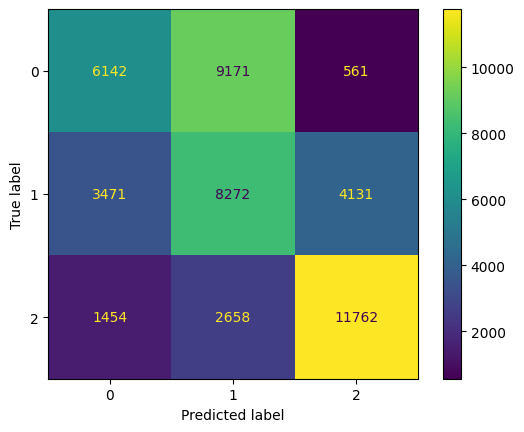

Cluster Model Accuracy on Train Set: 0.5497


In [57]:
placeholder=firstrun.copy()
for i in range(len(bests)):
    placeholder[placeholder == bests[i][1]] = bests[i][2]
cf1r = confusion_matrix(scorestr.ScoreNum,placeholder)
cf1rdisp = ConfusionMatrixDisplay(cf1r)
cf1rdisp.plot()
plt.show()
kmpredtr = round(accuracy_score(scorestr.ScoreNum,placeholder),4)
print("Cluster Model Accuracy on Train Set:", kmpredtr)

Not bad, the classifier scores better than 50% accuracy even though we stripped out 1/3 of the data. Let's see how the model does on the test set.

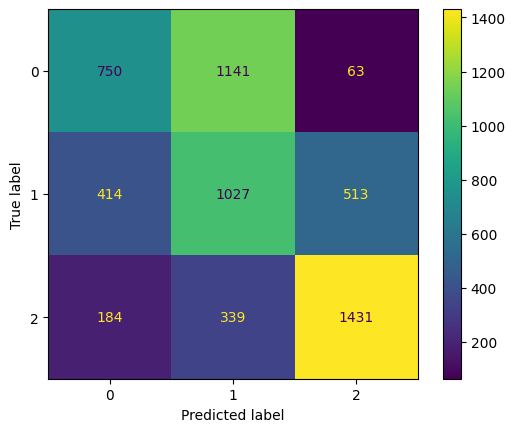

Cluster Model Test Set Accuracy: 0.5473
Completed in  0.02548360824584961  seconds.


In [58]:
t0 = time.time()
testrun = km.predict(scores2te.iloc[:,1:-1])
for i in range(len(bests)):
    testrun[testrun == bests[i][1]] = bests[i][2]
kmt2 =  round(time.time()-t0,3)
cf1rt = confusion_matrix(scores2te.ScoreNum,testrun)
cf1rtdisp = ConfusionMatrixDisplay(cf1rt)
cf1rtdisp.plot()
plt.show()
kmpredte = round(accuracy_score(scores2te.ScoreNum,testrun),4)
print("Cluster Model Test Set Accuracy:", kmpredte)
print("Completed in ",kmt2, ' seconds.')

Not bad, the classifier scores better than 50% accuracy on both the train and test sets even though we stripped out 1/3 of the data. Better yet, the training and test sets have similar accuracy metrics (.0024 difference). The model generalized well on unseen data proving it's capability at predicting on unseen data. Knowing that we have stripped a sizeable amount of this dataset that's amazing. One thing to note before we move on, that algorithm was computed in seconds (less than 2). The speed and accuracy is why we tried this algorithm first. Let's move on and see if we can improve our scores with an agglomerative clustering.

# Agglomerative Clustering Classifier

Again, we'll use our test dataframe with normalized data, and then run the clustering model (setting n_clusters = 3).

In [74]:
t0 = time.time()

#Build the classifier
km2 = AgglomerativeClustering(n_clusters=3, linkage='ward' )

#run it
secondrun = km2.fit_predict(scores2.iloc[:,1:-1])
ag1 = round(time.time()-t0,3)
print("Predictions type and values:",type(secondrun),len(secondrun),secondrun)
print("Completed in ", ag1, ' seconds.')

Predictions type and values: <class 'numpy.ndarray'> 47622 [0 0 2 ... 1 0 0]
Completed in  153.333  seconds.


Now that we have results, we go through and match them to the target variables again for scoring. Notice that we'll have to pick the second best option for one of the classes by hand. We choose the pair that adds up to the most correct classifications. 

(In this example: 18.7% + 9.9% = 28.6% vs 22.6% + 7.9% = 30.3%)

Cluster: 0  Val: 3  Acc: 0.22630296921590862
Cluster: 1  Val: 3  Acc: 0.0070765612532023014
Cluster: 2  Val: 3  Acc: 0.09995380286422242
Cluster: 0  Val: 4  Acc: 0.18722439208769057
Cluster: 1  Val: 4  Acc: 0.0667758598966864
Cluster: 2  Val: 4  Acc: 0.07933308134895636
Cluster: 0  Val: 5  Acc: 0.08002603838562009
Cluster: 1  Val: 5  Acc: 0.2250850447272269
Cluster: 2  Val: 5  Acc: 0.02822225022048633
Best Outputs: [[0.22630296921590862, 3, 0], [0.18722439208769057, 4, 0], [0.2250850447272269, 5, 1]]
Hand Altered Best Outputs: [[0.22630296921590862, 3, 0], [0.079, 4, 2], [0.2250850447272269, 5, 1]]


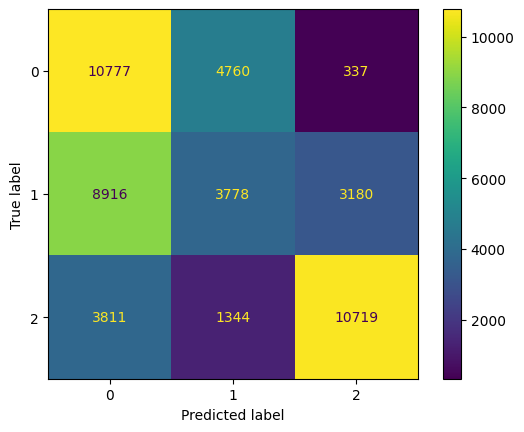

Cluster Model Accuracy on Training Set: 0.5307


In [60]:
bests = []
for i in range(3,6):
    placeholder = []
    accstep = 0
    clu = ''
    val = ''
    for j in range(3):
        placeholder = secondrun.copy()
        #print(len(placeholder))
        placeholder[placeholder == j] = i
        accs = accuracy_score(scores2.ScoreNum,placeholder)
        print("Cluster:",j," Val:",i," Acc:",accs)
        if accs > accstep:
            accstep = accs
            val = j
            clu = i
    bests.append([accstep,clu,val])
print("Best Outputs:",bests)
bests[1][2]= 2
bests[1][0]= .079
print("Hand Altered Best Outputs:",bests)

placeholder=secondrun.copy()
for i in range(len(bests)):
    placeholder[placeholder == bests[i][2]] = bests[i][1]
cf2r = confusion_matrix(scores2.ScoreNum,placeholder)
cf2rdisp = ConfusionMatrixDisplay(cf2r)
cf2rdisp.plot()
plt.show()
agpredtr = round(accuracy_score(scores2.ScoreNum,placeholder),4)
print("Cluster Model Accuracy on Training Set:",agpredtr )

Again, amazingly, the clustering algorithm is better than guessing at a very difficult classification task. Here our Agglomerative clustering algorithm was able to correctly separate the classes with ~53% accuracy. This is not better than our KMeans attempt using the same data. Although this approach isn't adequate for implementation, it does again show that clustering can be a fairly powerful classifier on data seen at training time. One issue with Agglomerative clustering as a classifier is the lack of a predict capability. The agglomerative model is incapable of running the test set for validation without retraining on both sets. This is by construction and illustrates a limit of using Agglomerative (or DBSCAN or HDBSCAN) algorithms as a predictive classifier.

# Random Forest Classifier as a Benchmark

We'll use optuna to tune our classifier on the same data frame for training the clustering algorithms first. Our plan is to then retrain the model on the optimal parameters. We'll take a look at the tuning process before we do so. Optuna is hooked up to SHAP so we get some pretty visuals with single lines of code.

Once we have a trained and tuned model, we'll measure the results. We'll predict the training set accuracy, and again on the test set. Let's get to work.

In [61]:
t0= time.time()
# run a hyperparamter tuning trial
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 3000)
    max_depth = trial.suggest_int('max_depth',12,120)
    max_samples = trial.suggest_int('max_samples',1200,30000)
    clf = RandomForestClassifier(n_estimators = n_estimators,
                                max_depth = max_depth,
                                max_samples = max_samples,
                                random_state= 12,
                                min_impurity_decrease=.000001,
                                verbose = False)
    return cross_val_score(clf,scores3.iloc[:,1:-1],scores3.ScoreNum,n_jobs=-1,cv=3).mean()
study = optuna.create_study(direction='maximize')
study.optimize(objective,n_trials = 25)
trial = study.best_trial
print('Accuracy:', trial.value)
print('Best Hyperparameters: ', trial.params)
rft0 = round(time.time()-t0,3)
print("Completed in ",rft0, ' seconds.')

[I 2023-11-27 06:17:21,919] A new study created in memory with name: no-name-6b5bd724-2d08-427a-83f9-91af97b59d84
[I 2023-11-27 06:19:00,110] Trial 0 finished with value: 0.7334425265633531 and parameters: {'n_estimators': 2960, 'max_depth': 90, 'max_samples': 3338}. Best is trial 0 with value: 0.7334425265633531.
[I 2023-11-27 06:20:41,118] Trial 1 finished with value: 0.8032002015875016 and parameters: {'n_estimators': 551, 'max_depth': 37, 'max_samples': 29724}. Best is trial 1 with value: 0.8032002015875016.


Accuracy: 0.8032002015875016
Best Hyperparameters:  {'n_estimators': 551, 'max_depth': 37, 'max_samples': 29724}
Completed in  199.20451974868774  seconds.


In [62]:
optuna.visualization.plot_contour(study,params=['n_estimators','max_depth'])

In [63]:
optuna.visualization.plot_contour(study,params=['max_depth','max_samples'])

In [64]:
optuna.visualization.plot_optimization_history(study)

In [65]:
optuna.visualization.plot_slice(study)

Completed in 4.305720567703247 seconds.


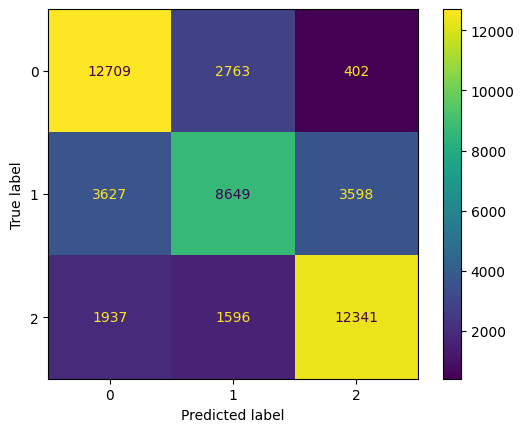

Random Forest Model Accuracy on Training Set: 0.7076


In [66]:
# Rebuild the model and train it up

t0 = time.time()
clffin = RandomForestClassifier(n_estimators = trial.params['n_estimators'],
                               max_depth =  trial.params['n_estimators'],
                               max_samples =  trial.params['n_estimators'],
                               random_state = 12,
                               min_impurity_decrease = .00001,
                               verbose = False).fit(scores3.iloc[:,1:-1],scores3.ScoreNum)
rft1 = round(time.time()-t0,3)
print(f"Completed in {rft1} seconds.")

# make predictions with the final model on training set
predstrain = clffin.predict(scores3.iloc[:,1:-1])

# visualize the results
cf1rf = confusion_matrix(scores3.ScoreNum,predstrain)
cf1rfdisp = ConfusionMatrixDisplay(cf1rf)
cf1rfdisp.plot()
plt.show()
rfpredtr = round(accuracy_score(scores3.ScoreNum,predstrain),4)
print("Random Forest Model Accuracy on Training Set:", rfpredtr)

Cool, we have a tuned random forest classifier performing roughly 20 points better than the clustering algorithm on the training set. Let's see how it generalizes to the testing set.

Completed in 0.4702930450439453 seconds.


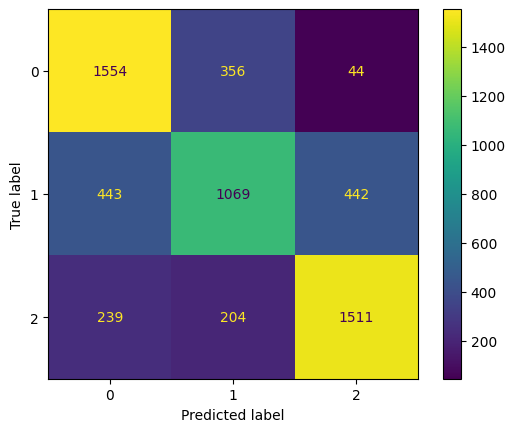

Random Forest Model Accuracy on Testing Set: 0.7052


In [67]:
t0 = time.time()
# make predictions with the final model on training set

predstest = clffin.predict(scores3te.iloc[:,1:-1])
rft2 = round(time.time()-t0,3)
print(f"Completed in {rft2} seconds.")

# visualize the results
cf1rft = confusion_matrix(scores3te.ScoreNum,predstest)
cf1rftdisp = ConfusionMatrixDisplay(cf1rft)
cf1rftdisp.plot()
plt.show()
rfpredte = round(accuracy_score(scores3te.ScoreNum,predstest),4)
print("Random Forest Model Accuracy on Testing Set:", rfpredte)

The random forest classifier generalized well, only losing a point on the testing set. 

# Conclusion:
This notebook shows that clustering algorithms can classify observations. Our data was stripped down, so we aren't looking for perfect scores (best case is under 75%). Our clustering algorithms were still able to get over 50%, meaning they are significantly better than guessing and get over 2/3 of the data the tuned supervised approach accuracy.

* The basic KMeans clustering approach yielded the best unsupervised accuracy on both training and test set data. This algorithm proved capable of both fitting clusters to classes and making predictions on unseen data.
* The more complex agglomerative clustering scored similarly on the training set, but isn't able to make predictions on unseen data by construction. Therefore, agglomerative clustering proved a feasible classification technique on seen data only. 
* The Capability Metrics in the tables below compare the accuracy of the model against the best case scenario. Both Unsupervised Clustering algorithms score over 70, and one can predict on unseen data. While the supervised model scores over 90 on both train and test sets. This shows the relative stregth of the unsupervised methods and the agglomerative methods predict limitation.
* While neither clustering classifier is as accurate as a tuned random forest classifier. However, the clustering methods took seconds to build and run. The random forest model took over 90 minutes. The tests confirmed that clustering classifiers are orders of magnitude faster to set up and institute and yield better than average results. 

If you liked this notebook, please up vote.

In [81]:
# Accuracy Metrics
results = pd.DataFrame({"Model":["Best Case","KMeans","Agglomerative","Random Forest"],"Training Accuracy":[.75,kmpredtr,agpredtr,rfpredtr],"Testing Accuracy":[.75,kmpredte,0,rfpredte]})
results['Train Capability']= [int(x*100/.75) for x in results['Training Accuracy']] 
results['Test Capability']= [int(x*100/.75) for x in results['Testing Accuracy']]
results

,Model,Training Accuracy,Testing Accuracy,Train Capability,Test Capability
0,Best Case,0.7500,0.7500,100,100
1,KMeans,0.5497,0.5473,73,72
2,Agglomerative,0.5307,0.0000,70,0
3,Random Forest,0.7076,0.7052,94,94


In [76]:
# Time Metrics
resultst = pd.DataFrame({"Model":["KMeans","Agglomerative","Random Forest"],"Tuning Time":[0,0,rft0],"Training Set Time":[kmt1,ag1,rft1],"Testing Set Time":[kmt2,0,rft2]})
resultst['Total Time'] = resultst["Tuning Time"] + resultst['Training Set Time'] + resultst['Testing Set Time'] 
resultst

,Model,Tuning Time,Training Set Time,Testing Set Time,Total Time
0,KMeans,0.0000,1.9838,0.0255,2.0092
1,Agglomerative,0.0000,153.3330,0.0000,153.3330
2,Random Forest,199.2045,4.3057,0.4703,203.9805
